In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn 
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [43]:
path = "data/Battery_RUL.csv"

In [44]:
data = pd.read_csv(path)

In [45]:
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [46]:
data.shape

(15064, 9)

In [47]:
# 다음 컬럼들은 RUL에 관계가 없기 때문에 제거한다.
data=data.drop(['Cycle_Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time constant current (s)','Charging time (s)'],axis=1)

In [48]:
data.head()

,Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),RUL
0,3.670,3.211,5460.001,1112
1,4.246,3.220,5508.992,1111
2,4.249,3.224,5508.993,1110
3,4.250,3.225,5502.016,1109
4,4.290,3.398,5480.992,1107


## Modeling and Predections

In [49]:
X = data.drop(['RUL'], axis=1)
y = data['RUL']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2023, shuffle =True)

In [51]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y

In [52]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
pipeline = Pipeline(robust)

In [53]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [54]:
X_train_s = torch.FloatTensor(X_train_s)
y_train_s = torch.FloatTensor(y_train_s).unsqueeze(-1)

In [55]:
X_train_s.shape, y_train_s.shape

(torch.Size([10092, 3]), torch.Size([10092, 1]))

In [56]:
# 분석단위의 shape
nfeatures = X_train_s.shape[1] #num of columns
nfeatures

3

In [57]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [67]:
input_size = 3
hidden_size = 16
num_classes = 1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 700], gamma=0.5)


In [68]:
for epoch in range(1, 10001):
    optimizer.zero_grad()
    outputs = model(X_train_s)
    loss = criterion(outputs, y_train_s)
    loss.backward()
    optimizer.step()
    scheduler.step()
    print(f'Epoch : {epoch} / loss : {loss.item()}')

Epoch : 1 / loss : 408650.71875
Epoch : 2 / loss : 407858.6875
Epoch : 3 / loss : 406932.9375
Epoch : 4 / loss : 405698.65625
Epoch : 5 / loss : 404071.6875
Epoch : 6 / loss : 402034.0625
Epoch : 7 / loss : 399558.1875
Epoch : 8 / loss : 396620.6875
Epoch : 9 / loss : 393220.5
Epoch : 10 / loss : 389361.21875
Epoch : 11 / loss : 385054.21875
Epoch : 12 / loss : 380320.21875
Epoch : 13 / loss : 375190.15625
Epoch : 14 / loss : 369705.0625
Epoch : 15 / loss : 363916.3125
Epoch : 16 / loss : 357883.1875
Epoch : 17 / loss : 351665.59375
Epoch : 18 / loss : 345315.1875
Epoch : 19 / loss : 338874.125
Epoch : 20 / loss : 332368.90625
Epoch : 21 / loss : 325795.625
Epoch : 22 / loss : 319104.21875
Epoch : 23 / loss : 312209.875
Epoch : 24 / loss : 305020.0
Epoch : 25 / loss : 297463.4375
Epoch : 26 / loss : 289503.875
Epoch : 27 / loss : 281132.21875
Epoch : 28 / loss : 272364.8125
Epoch : 29 / loss : 263330.78125
Epoch : 30 / loss : 254004.84375
Epoch : 31 / loss : 244512.984375
Epoch : 32 / 

In [60]:
# 함수로 만들어서 사용합시다.
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [61]:
def visualization_result(y_val,pred, size=100):
  sns.lineplot(y_val[:size].values, label='valid train')
  sns.lineplot(pred.reshape(pred.shape[0],)[:size], label='pred')
  plt.legend(loc='upper right')
  plt.show()

In [62]:
dl_history_plot(hist)

NameError: name 'hist' is not defined

In [63]:
from sklearn.metrics import * 

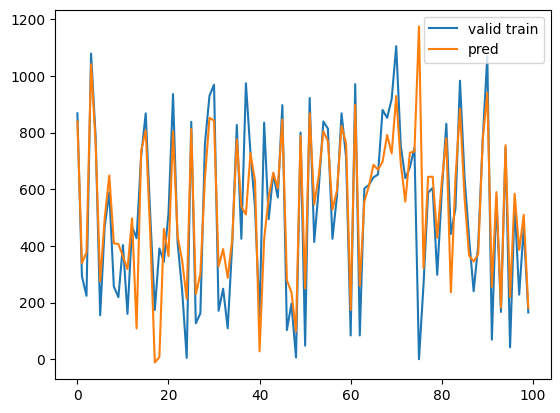

In [28]:
visualization_result(y_test_s,pred,size=100)

In [29]:
clear_session()

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU'),
    Dense(16, input_shape=(32,), activation='ELU'),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

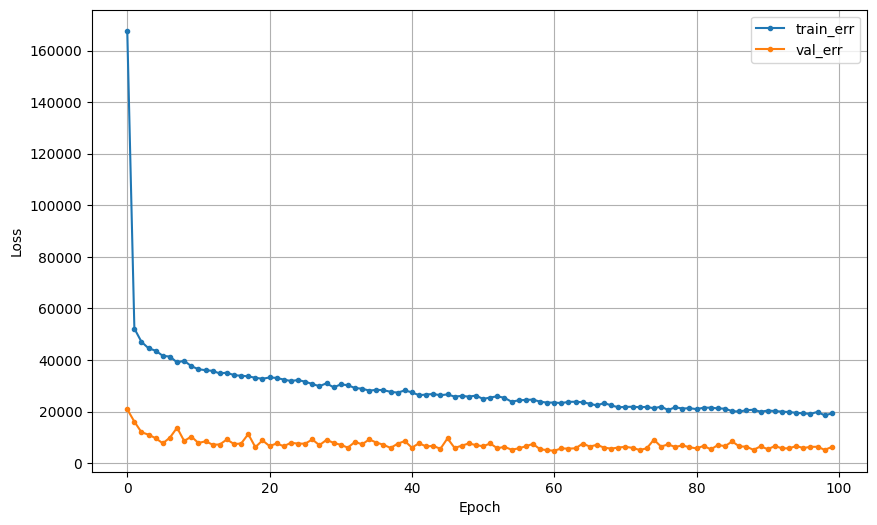

In [30]:
dl_history_plot(hist)

In [31]:
pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')

RMSE : 70.70289189255601
MAE  : 54.542563414679165
MAPE : 1886268809472397.5
R2 : 0.9516721659815035


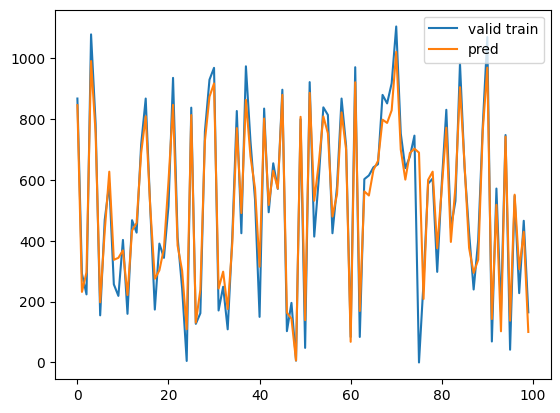

In [32]:
visualization_result(y_test_s,pred,size=100)

In [33]:
clear_session()
from tensorflow.keras.regularizers import l1, l2

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dense(16, input_shape=(32,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

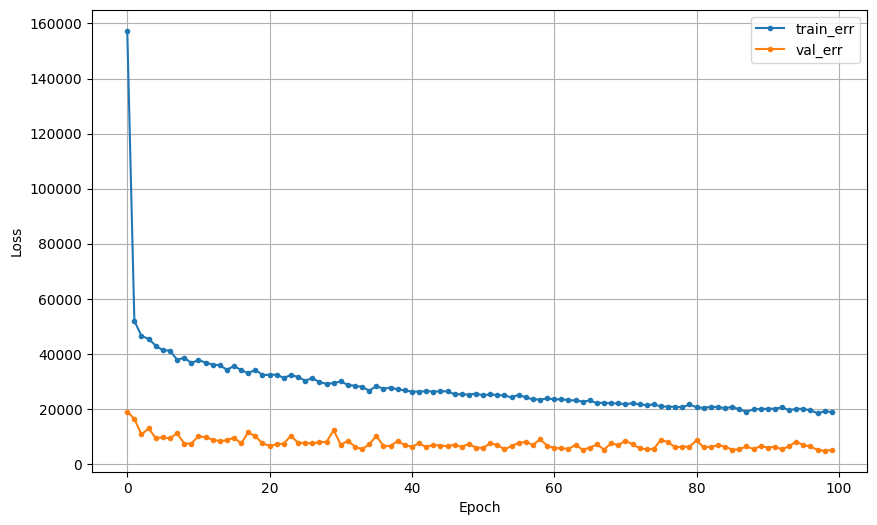

RMSE : 61.69550065151493
MAE  : 46.079332333534644
MAPE : 1827158615447511.2
R2 : 0.9632015131060703


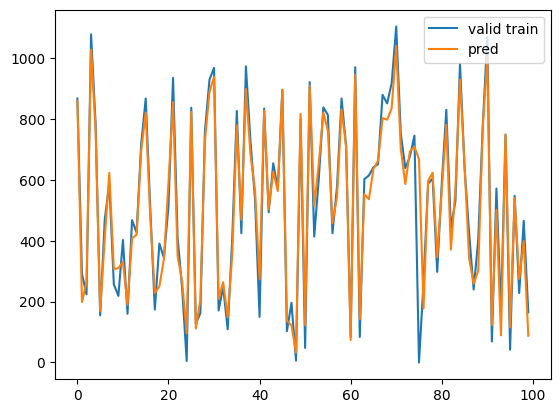

In [34]:
dl_history_plot(hist)

pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')

visualization_result(y_test_s,pred,size=100)